## **Citation Network Analysis**
**Note**: This is an ongoing personal research project. More modifications will be included in future versions

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/citation-network-dataset/dblp.v12.json


In [3]:
import bigjson
from igraph import *
import igraph as ig
from cairo import *
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

## **Data Preparation**
**Note**: We will consider only **<=130** publications due to low computational cost and clearer visualizations formed by smaller subset

#### The loop below is inefficient and renders the required results in a lot of time (needs work)

In [4]:
count  = 300
final = count + 130
references_dict = {'id':[],
                  'title':[],
                  'doc_type':[],
                  'publisher':[],
                  'venue_name':[],
                  'venue_ID':[],
                  'references':[]}

with open('../data/DBLP_v12/dblp.v12.json', 'rb') as f:
    j = bigjson.load(f)
    while count < final:
        element = j[count]
        if 'references' in element.keys():
            for i,val in enumerate(element['references']):
                references_dict['references'].append(element['references'][i])
                references_dict['id'].append(element['id'])
                references_dict['title'].append(element['title'])
                if element['publisher'] != "":
                     references_dict['publisher'].append(element['publisher'])
                else:
                     references_dict['publisher'].append(np.nan)
                if element['doc_type'] != "":
                    references_dict['doc_type'].append(element['doc_type'])
                else:
                    references_dict['doc_type'].append(np.nan)
                if 'venue' in element.keys():
                    if 'raw' in element['venue'].keys():
                        references_dict['venue_name'].append(element['venue']['raw'])
                    else:
                        references_dict['venue_name'].append(np.nan)
                    if 'id' in element['venue'].keys():
                        references_dict['venue_ID'].append(element['venue']['id'])
                    else:
                        references_dict['venue_ID'].append(np.nan)
                else:
                    references_dict['venue_name'].append(np.nan)
                    references_dict['venue_ID'].append(np.nan)

        else:
            references_dict['references'].append(np.nan)
            references_dict['id'].append(element['id'])
            references_dict['title'].append(element['title'])
            
            if element['publisher'] != "":
                references_dict['publisher'].append(element['publisher'])
            else:
                references_dict['publisher'].append(np.nan)
            
            if element['doc_type'] != "":
                    references_dict['doc_type'].append(element['doc_type'])
            else:
                    references_dict['doc_type'].append(np.nan)
                
            if 'venue' in element.keys():
                    if 'raw' in element['venue'].keys():
                        references_dict['venue_name'].append(element['venue']['raw'])
                    else:
                        references_dict['venue_name'].append(np.nan)
                    if 'id' in element['venue'].keys():
                        references_dict['venue_ID'].append(element['venue']['id'])
                    else:
                        references_dict['venue_ID'].append(np.nan)
            else:
                    references_dict['venue_name'].append(np.nan)
                    references_dict['venue_ID'].append(np.nan)
        
        count = count + 1

In [5]:
data = pd.DataFrame.from_dict(references_dict)
data.head(5)

,id,title,doc_type,publisher,venue_name,venue_ID,references
0,268983,"Dot, line, network: helping individuals make s...",Conference,"Springer, Berlin, Heidelberg","International Conference of Design, User Exper...",2.756350e+09,2.019971e+09
1,268983,"Dot, line, network: helping individuals make s...",Conference,"Springer, Berlin, Heidelberg","International Conference of Design, User Exper...",2.756350e+09,2.798791e+09
2,270053,Interactive listening to structured speech con...,Conference,NaN,Conference of the International Speech Communi...,1.177287e+09,1.929937e+09
3,271214,Visualizing patterns in the air quality in mex...,Conference,"Springer, Berlin, Heidelberg",Workshop on Self-Organizing Maps,2.757794e+09,2.158364e+09
4,272511,Evaluations of evidence combination rules in t...,Conference,IEEE,International Conference on Information Fusion,2.623423e+09,1.527532e+09


#### We keep unique values in the **id** column and non-null values in **references** colunmn along with corresponding values of **doc_type** column

In [6]:
reference_doc = pd.concat([data.loc[:,['id', 'doc_type']].drop_duplicates(), data[data['references'].notna()].loc[:, ['references', 'doc_type']].rename(columns = {'references': 'id'})],axis = 0).sort_values(by=['id'])
reference_list = list(reference_doc['id'].values)
doc_list = list(reference_doc['doc_type'].values)
count = len(reference_list)

In [7]:
references_graph = Graph(directed = False)
references_graph.add_vertices(count)
references_graph.vs['id_reference'] = reference_list
references_graph.vs['doc_type'] = doc_list

In [8]:
def add_edge(x):
    """
    This function adds an edge (u,v) with: 
    u = index of 'id' vertex
    v = index of 'references' vertex, with duplicate values being considered different 
    """
    references_graph.add_edge(reference_list.index(x.id),reference_list.index(x.references))
    return x.id,x.references

In [9]:
temp = data[data['references'].notna()].apply(add_edge, axis = 1)

## **Network Visualizations**
* The graph below shows a small network of publications (number = 130) along with their references
* Color indicates the 'doc_type' of the publication; each reference has been colored with the same color as its source i.e., the concered publication
* As expected, majority of references are refered only once in the small subset; a few have around 2 publications refering them

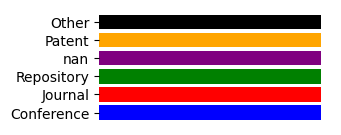

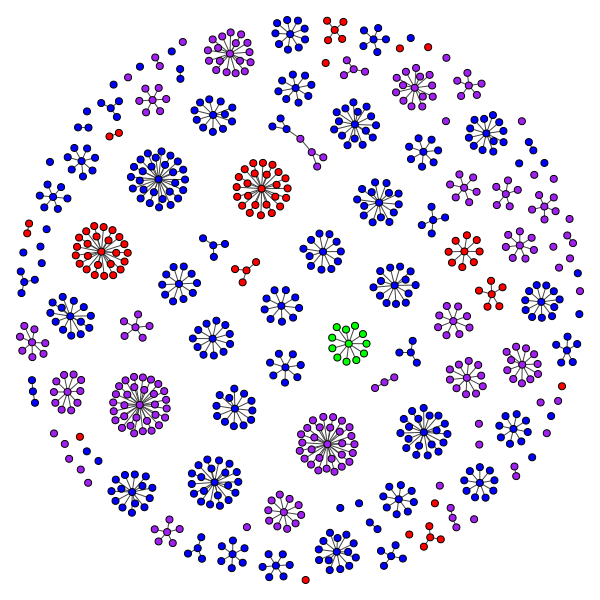

In [10]:
color_dict = {"Conference": "blue", 
              "Journal": "red", 
              "Repository": "green",
               np.nan: "purple",
              'Patent': 'orange',
              'Other': 'black'}

x = list(str(i) for i in color_dict.keys())
y = [5 for i in range(len(x))]
fig = plt.figure(figsize = (3,1.5))
ax1 = plt.axes(frameon=False)
ax1.axes.get_xaxis().set_visible(False)
plt.barh(x,y, 
         color = list(color_dict.values()))
plt.show()

references_graph.vs["color"] = [color_dict.get(doc_type,'black') for doc_type in references_graph.vs["doc_type"]]
ig.plot(references_graph,
        vertex_size=7)

In [13]:
pd.read_feather("../data/DBLP_v12/papers_references.feather")

,id,references
0,1091,2005687710
1,1091,2018037215
2,1388,-1
3,1674,1535888970
4,1674,1992876689
...,...,...
46681118,999847014,-1749987118
46681119,9990887,-1
46681120,99956490,2032457623
46681121,99956490,2094542439
